# Loan default prediction challenge

# Data description

Kowope Mart is a Nigerian-based retail company with a vision to provide quality goods, education and automobile services to its customers at affordable price and reduce if not eradicate charges on card payments and increase customer satisfaction with credit rewards that can be used within the Mall. To achieve this, the company has partnered with DSBank on co-branded credit card with additional functionality such that customers can request for loan, pay for goods even with zero-balance and then pay back within an agreed period of time. This innovative strategy has increased sales for the company. However, there has been recent cases of credit defaults and Kowope Mart will like to have a system that profiles customers who are worthy of the card with minimum if not zero risk of defaulting.

The data set can be accessed using the link below: https://zindi.africa/hackathons/dsn-ai-bootcamp-qualification-hackathon
        
The basis of the project is to predict customers who are likely to default or not.

default_status: defaulted or not. (yes:1, no: 0)

In [ ]:
#Data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

import os, sys
import warnings
warnings.filterwarnings('ignore')
import pandas.util.testing as tm

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab/loan_train.csv')

test = pd.read_csv('/content/drive/My Drive/Colab/loan_test.csv')

In [ ]:
train.shape, test.shape

((56000, 52), (24000, 51))

In [ ]:
data = train.copy()

In [ ]:
data.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,4397256.0,2301324.0,7875694.0,96375139.0,112181765.0,1.0,1.0,1.0,3.0,3.0,134.655,NaN,NaN,134.655,4000.5,17064.0,11376.0,60.0,17064.0,5962.0,NaN,1052.0,8.0000,2.0,NaN,12.0,12.0,4.0,0.0,NaN,NaN,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,no
1,Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,244292.0,3982971.0,2141445.0,28141427.0,45169902.0,1.0,1.0,1.0,2.0,2.0,109.230,11385.24,14584.29,86.685,4161.0,13413.0,8942.0,304.0,13413.0,5780.0,NaN,2554.0,17.5000,0.0,0.0,16.0,24.0,8.0,0.0,NaN,NaN,0.314281,8.08,0.183584,NaN,0.0,charge,349.805730,1.620483,0.322436,no
2,Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,NaN,0.0,16576457.0,22452691.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,NaN,14508.0,70.0,0.6666,0.0,NaN,12.0,0.0,6.0,0.0,149.6805,NaN,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,yes
3,Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,NaN,771776.0,1186839.0,48187375.0,136297820.0,0.0,0.0,0.0,1.0,1.0,120.120,8580.00,0.00,85.800,1701.0,4014.0,2676.0,60.0,11679.0,NaN,NaN,522.0,7.8334,1.0,1.0,4.0,8.0,4.0,1.0,NaN,NaN,0.488884,2.02,0.685168,NaN,0.0,charge,89.940100,0.664452,0.082729,no
4,Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,396391.0,818456.0,511535.0,28141427.0,15292757.0,0.0,0.0,0.0,3.0,3.0,104.535,8360.19,10326.45,115.335,1551.0,3285.0,2190.0,60.0,19437.0,12958.0,5202.0,272.0,1.0000,0.0,0.0,24.0,2.0,24.0,0.0,150.0135,NaN,0.275000,12.12,0.438168,0.0,0.0,charge,97.887502,1.427891,0.045630,no


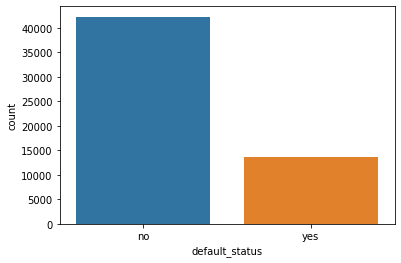

In [ ]:
sns.countplot('default_status', data = data )

In [ ]:
def func(data):
    d =[]
    for m in data:
        if m =='yes':
            d.append(1)
        else:
            d.append(0)
    return d

data['default_status'] = func(data['default_status'])

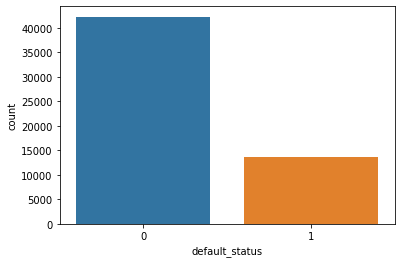

In [ ]:
sns.countplot('default_status', data=data )

In [ ]:
dict_formfield47 = {'charge': 1,
         'lending': 0}


data['form_field47'].replace(dict_formfield47, inplace = True)
test['form_field47'].replace(dict_formfield47, inplace = True)

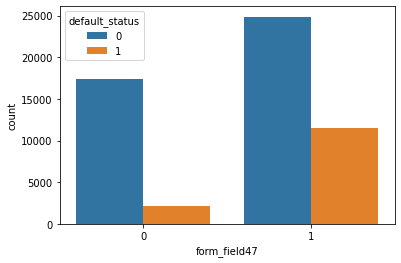

In [ ]:
sns.countplot('form_field47', data = data, hue = 'default_status' )

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Applicant_ID    56000 non-null  object 
 1   form_field1     53471 non-null  float64
 2   form_field2     52156 non-null  float64
 3   form_field3     55645 non-null  float64
 4   form_field4     55645 non-null  float64
 5   form_field5     55645 non-null  float64
 6   form_field6     42640 non-null  float64
 7   form_field7     50837 non-null  float64
 8   form_field8     42640 non-null  float64
 9   form_field9     47992 non-null  float64
 10  form_field10    55645 non-null  float64
 11  form_field11    24579 non-null  float64
 12  form_field12    46105 non-null  float64
 13  form_field13    50111 non-null  float64
 14  form_field14    56000 non-null  float64
 15  form_field15    33525 non-null  float64
 16  form_field16    42964 non-null  float64
 17  form_field17    44849 non-null 

In [ ]:
data_id = data['Applicant_ID']
data = data.drop('Applicant_ID', axis = 1)

test_id = test['Applicant_ID']
test = test.drop('Applicant_ID', axis = 1)

In [ ]:
data = data.drop(['form_field48'], axis =1)
test = test.drop(['form_field48'], axis =1)

data = data.drop(['form_field49'], axis =1)
test = test.drop(['form_field49'], axis =1)

In [ ]:
df_features = data.select_dtypes(exclude = object).columns.drop(['default_status'])

In [ ]:
for feat in df_features:
    data[feat].fillna(-999, inplace = True)
    test[feat].fillna(-999, inplace = True)

In [ ]:
x = data[df_features]
y = data['default_status']

In [ ]:
!pip install catboost

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
def metric(y, prediction):
    return roc_auc_score(y, prediction, labels=[0, 1])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 42)

In [ ]:
import lightgbm as lgb

seed = 2020
num_skf = 15
kfold= StratifiedKFold(num_skf)

parameter_lgb= {
    'max_depth': 8,
    'learning_rate': 0.01,
    'n_estimators': 5000,
    'min_child_weight' : 80,
    'colsample_bytree': 0.5,
    'random_state': 50,
    'colsample_bylevel': 0.6,
    'random_seed': seed,
    'early_stopping_rounds': 200,
    'use_best_model': True,
}

In [ ]:
score_list = []
score = 0
test_oofs1 = []

for i, (tr_index, vr_index) in enumerate(kfold.split(x, y)):
    
    xtrain, ytrain = x.loc[tr_index, df_features], y.loc[tr_index]
    xval, yval = x.loc[vr_index, df_features], y.loc[vr_index]

    model1 = lgb.LGBMClassifier(**parameter_lgb)
    model1.fit(xtrain, ytrain, eval_set=[(xval,yval)], verbose=100)
    
    p1 = model1.predict_proba(xval)[:, 1]
    sc1 = metric(yval, p1)
    score_list.append(sc1)
    score += sc1/num_skf
    
    pred1 = model1.predict_proba(test[df_features])[:, 1]
    test_oofs1.append(pred1)

    print('Fold {} : {}'.format(i, sc1))

print()
print()
print('Avg log : ', score)
    

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's binary_logloss: 0.458437
[200]	valid_0's binary_logloss: 0.431951
[300]	valid_0's binary_logloss: 0.422558
[400]	valid_0's binary_logloss: 0.419088
[500]	valid_0's binary_logloss: 0.417226
[600]	valid_0's binary_logloss: 0.416242
[700]	valid_0's binary_logloss: 0.415654
[800]	valid_0's binary_logloss: 0.415145
[900]	valid_0's binary_logloss: 0.414788
[1000]	valid_0's binary_logloss: 0.414604
[1100]	valid_0's binary_logloss: 0.414605
[1200]	valid_0's binary_logloss: 0.414564
[1300]	valid_0's binary_logloss: 0.414544
[1400]	valid_0's binary_logloss: 0.414577
[1500]	valid_0's binary_logloss: 0.414574
Early stopping, best iteration is:
[1337]	valid_0's binary_logloss: 0.414473
Fold 0 : 0.8298675847149612
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's binary_logloss: 0.446935
[200]	valid_0's binary_logloss: 0.417425
[300]	valid_0's binary_logloss: 0.407076
[400]	valid_0's binary_lo

In [ ]:
f"{num_skf} fold CV, scoring: {score}"

'15 fold CV, scoring: 0.8404262770404335'

In [ ]:
oof_prediction1 = pd.DataFrame(test_oofs1).T


In [ ]:
oof_prediction1.columns = ['fold_'+ str(i) for i in range(1, num_skf + 1)]

In [ ]:
oof_prediction1.head()

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,fold_11,fold_12,fold_13,fold_14,fold_15
0,0.336954,0.331633,0.320915,0.354144,0.326450,0.339945,0.314877,0.366284,0.323897,0.305387,0.341136,0.323047,0.298107,0.337163,0.347035
1,0.352755,0.361673,0.350702,0.338422,0.314780,0.337678,0.380460,0.394792,0.357689,0.391991,0.285499,0.349259,0.387270,0.294255,0.341654
2,0.375210,0.378273,0.390580,0.426416,0.417604,0.429803,0.426616,0.438497,0.434573,0.402748,0.457885,0.392482,0.391493,0.387671,0.388008
3,0.696828,0.712446,0.708622,0.716882,0.735647,0.732309,0.721652,0.719596,0.742493,0.712810,0.731157,0.708332,0.697614,0.706227,0.721514
4,0.091197,0.120220,0.123094,0.122335,0.117347,0.118945,0.122331,0.118286,0.113578,0.151661,0.084501,0.115404,0.139771,0.101553,0.091903


In [ ]:
pred_lgb = np.mean(test_oofs1, axis = 0)
pred_lgb

array([0.33113159, 0.34925866, 0.40919049, ..., 0.24259979, 0.52645935,
       0.18952474])

In [ ]:
seed = 2020
num_skf = 15
kfold = StratifiedKFold(num_skf)

parameter_cat = {
    'eval_metric':'AUC',
    'random_seed': seed,
    'early_stopping_rounds': 200,
    'use_best_model': True,
    'max_depth': 8,
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'objective': 'CrossEntropy'
}

In [ ]:
score_list = []
score = 0
test_oofs2 = []

for i, (tr_index, vr_index) in enumerate(kfold.split(x, y)):
    
    xtrain, ytrain = x.loc[tr_index, df_features], y.loc[tr_index]
    xval, yval = x.loc[vr_index, df_features], y.loc[vr_index]

    model2 = CatBoostClassifier(**parameter_cat)
    model2.fit(xtrain, ytrain, eval_set=[(xval,yval)], verbose=100)
    
    p2 = model2.predict_proba(xval)[:, 1]
    sc2 = metric(yval, p2)
    score_list.append(sc2)
    score += sc2/num_skf
    
    pred2 = model2.predict_proba(test[df_features])[:, 1]
    test_oofs2.append(pred2)

    print('Fold {} : {}'.format(i, sc2))

print()
print()
print('Avg log : ', score)

0:	test: 0.7853921	best: 0.7853921 (0)	total: 123ms	remaining: 10m 16s
100:	test: 0.8185407	best: 0.8185407 (100)	total: 6.92s	remaining: 5m 35s
200:	test: 0.8210740	best: 0.8210752 (199)	total: 13.5s	remaining: 5m 23s
300:	test: 0.8229919	best: 0.8229919 (300)	total: 20.2s	remaining: 5m 14s
400:	test: 0.8244896	best: 0.8244896 (400)	total: 26.7s	remaining: 5m 5s
500:	test: 0.8257306	best: 0.8257306 (500)	total: 33.1s	remaining: 4m 57s
600:	test: 0.8267238	best: 0.8267482 (598)	total: 39.6s	remaining: 4m 49s
700:	test: 0.8276260	best: 0.8276260 (699)	total: 46.1s	remaining: 4m 42s
800:	test: 0.8282416	best: 0.8282428 (799)	total: 52.5s	remaining: 4m 35s
900:	test: 0.8287030	best: 0.8287185 (899)	total: 58.9s	remaining: 4m 27s
1000:	test: 0.8292391	best: 0.8292457 (998)	total: 1m 5s	remaining: 4m 20s
1100:	test: 0.8294330	best: 0.8294446 (1097)	total: 1m 11s	remaining: 4m 13s
1200:	test: 0.8299184	best: 0.8299335 (1197)	total: 1m 18s	remaining: 4m 6s
1300:	test: 0.8303227	best: 0.830331

In [ ]:
f"{num_skf} fold CV, scoring: {score}" 

'15 fold CV, scoring: 0.8420783959625271'

In [ ]:
oof_prediction2 = pd.DataFrame(test_oofs2).T
oof_prediction2.columns = ['fold_'+ str(i) for i in range(1, num_skf + 1)]

In [ ]:
oof_prediction2.head()

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,fold_11,fold_12,fold_13,fold_14,fold_15
0,0.300085,0.292262,0.316344,0.299777,0.327973,0.271505,0.278206,0.323768,0.289394,0.302436,0.298519,0.316031,0.275663,0.290427,0.287229
1,0.356180,0.346472,0.409944,0.382736,0.346462,0.442251,0.456009,0.411510,0.400694,0.418173,0.353457,0.366226,0.411049,0.350582,0.361001
2,0.371529,0.378428,0.362425,0.371627,0.374138,0.380084,0.382671,0.377765,0.371351,0.418959,0.388850,0.377568,0.351870,0.357025,0.367063
3,0.750252,0.751492,0.756798,0.758712,0.733064,0.774485,0.755159,0.771725,0.749622,0.724893,0.763447,0.761541,0.746778,0.756839,0.742392
4,0.160428,0.146856,0.186705,0.200760,0.136663,0.148799,0.171265,0.158676,0.164577,0.143653,0.157480,0.170063,0.180899,0.172800,0.156159


In [ ]:
pred_cat = np.mean(test_oofs2, axis = 0)

pred_cat

array([0.29797458, 0.38751632, 0.37542347, ..., 0.26641304, 0.5292881 ,
       0.19122189])

In [ ]:
sub = pd.read_csv('/content/drive/My Drive/Colab/SampleSubmission.csv')
pred = 0.2*pred_lgb + 0.8*pred_cat
sub['default_status']= pred


In [ ]:
data = sub.to_csv('cat_classifier11B.csv', index= False)

In [ ]:
from google.colab import files

In [ ]:
files.download('cat_classifier11B.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>